In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import statistics
import scipy as sp
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import warnings
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
#!pip install humanfriendly
from humanfriendly import format_timespan
import time

sns.set(context = 'notebook', palette = 'Spectral', style = 'darkgrid', font_scale = 1.5, color_codes = True)
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# import data, split independent variables and dependent variables
dataset = pd.read_csv('dataset.csv')
dataset = dataset.drop(['Report_Date'], axis=1)

In [3]:
dataset.head()

,Beds,Total_LTC_Resident_Cases,Total_LTC_Resident_Deaths,Total_LTC_HCW_Cases,1st_dose_staff_vac_rate,2nd_dose_staff_vac_rate,phu_ACTIVE_CASES,phu_RESOLVED_CASES,phu_DEATHS,phu_TOTAL_CASES,phu_CASE_FATALITY_RATE,phu_Daily_New_Cases,phu_1st_dose,phu_fully_vac,LTC_Mortality_Rate
0,129.0,1,0,1,0.87,0.84,152,21091,393,21243,0.018500,14,0.769336,0.662662,0.000000
1,90.0,5,0,7,0.56,0.51,417,162179,3460,162596,0.021280,40,0.787886,0.694052,0.000000
2,425.0,0,9,0,0.81,0.73,152,21091,393,21243,0.018500,14,0.769336,0.662662,0.021176
3,144.0,1,6,0,0.97,0.95,85,17305,217,17390,0.012478,5,0.842742,0.718034,0.041667
4,129.0,1,0,1,0.87,0.84,139,21125,393,21264,0.018482,5,0.770308,0.667107,0.000000


### Linear Regression

Multiple linear regression assumptions:
1. Linear relationship: There exists a linear relationship between each predictor variable and the response variable.

2. No Multicollinearity: None of the predictor variables are highly correlated with each other.

3. Independence: The observations are independent.

4. Homoscedasticity: The residuals have constant variance at every point in the linear model.

5. Multivariate Normality: The residuals of the model are normally distributed.

If one or more of these assumptions are violated, then the results of the multiple linear regression may be unreliable.

Assumption 1: Linear Relationship (Linearity)

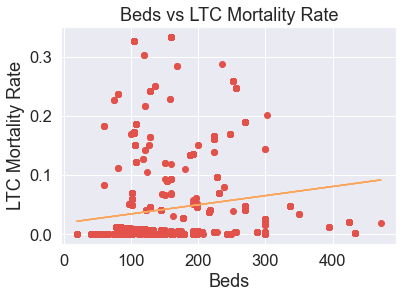

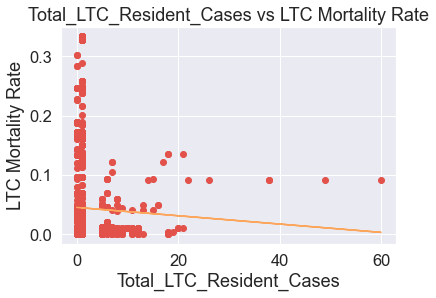

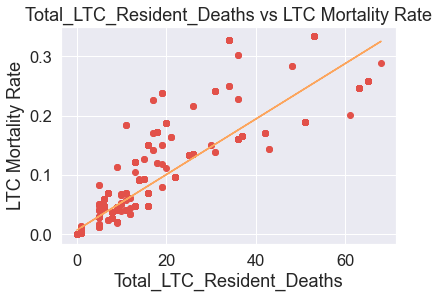

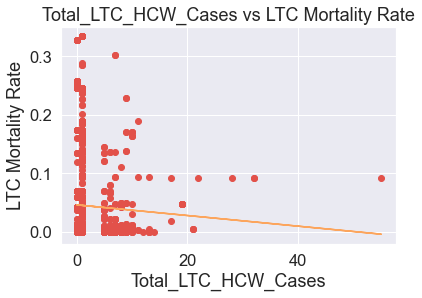

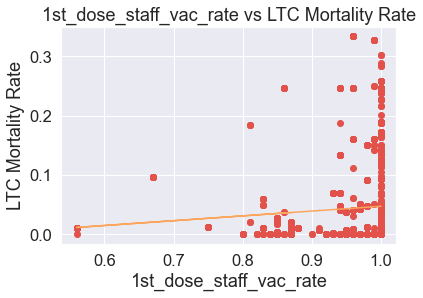

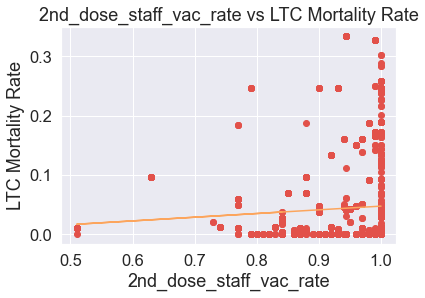

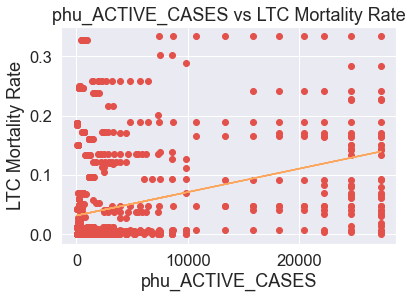

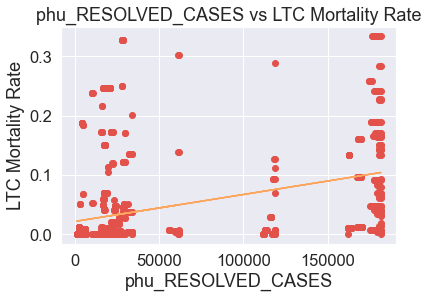

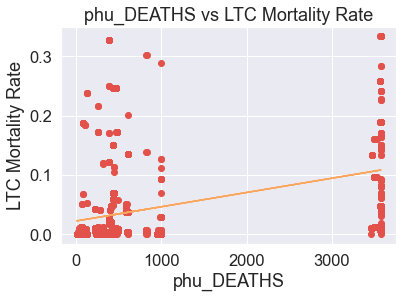

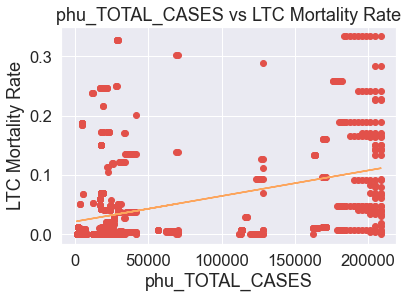

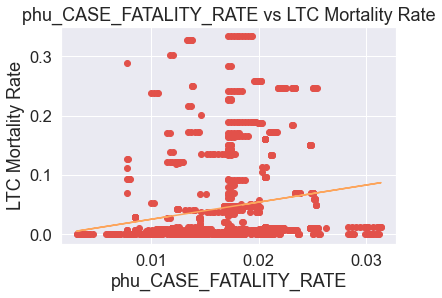

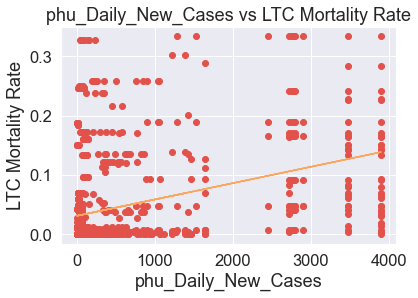

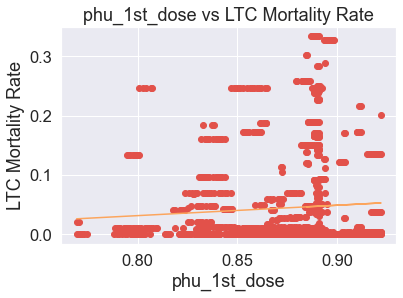

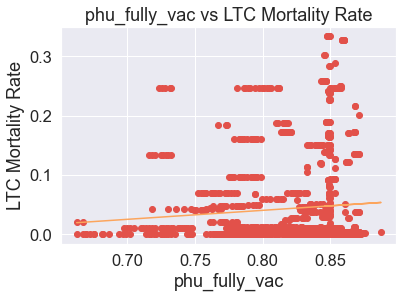

In [4]:
y = dataset.iloc[:,-1].values
for i in range(len(dataset.columns)-1):
    x = dataset.iloc[:,i].values
    plt.plot(x, y, 'o')
    m,b = np.polyfit(x,y,1)
    plt.plot(x,m*x + b)
    plt.title( dataset.columns[i] +' vs LTC Mortality Rate')
    plt.xlabel(dataset.columns[i])
    plt.ylabel('LTC Mortality Rate')
    plt.show()
    

Assumption 2: No Multicollinearity

The easiest way to determine if this assumption is met is to calculate the VIF value for each predictor variable.

VIF values start at 1 and have no upper limit. As a general rule of thumb, VIF values greater than 5* indicate potential multicollinearity.

In [5]:
X = dataset.iloc[:,:-1]
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i)
                  for i in range(len(X.columns))]
print(vif_data)

                      feature          VIF
0                        Beds     6.229962
1    Total_LTC_Resident_Cases     1.840177
2   Total_LTC_Resident_Deaths     1.926659
3         Total_LTC_HCW_Cases     2.543433
4     1st_dose_staff_vac_rate  3514.603741
5     2nd_dose_staff_vac_rate  3024.652306
6            phu_ACTIVE_CASES          inf
7          phu_RESOLVED_CASES          inf
8                  phu_DEATHS    41.561553
9             phu_TOTAL_CASES          inf
10     phu_CASE_FATALITY_RATE    15.297434
11        phu_Daily_New_Cases    57.105979
12               phu_1st_dose  5052.365181
13              phu_fully_vac  5466.257874


#### Linear Regression using statsmodels

In [6]:
X = dataset.iloc[:, :-1]
y = dataset.iloc[:, -1]

sc = StandardScaler()
X = sc.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [7]:
X_with_constant = sm.add_constant(X_train)
model = sm.OLS(y_train, X_with_constant)

In [8]:
results = model.fit()
results.params

const    0.043538
x1      -0.012967
x2       0.002083
x3       0.073730
x4      -0.003258
x5      -0.000643
x6      -0.002704
x7       0.009866
x8      -0.000540
x9      -0.003221
x10      0.000433
x11     -0.000731
x12     -0.003163
x13      0.001321
x14      0.004098
dtype: float64

In [9]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:     LTC_Mortality_Rate   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     568.9
Date:                Wed, 20 Apr 2022   Prob (F-statistic):               0.00
Time:                        05:36:17   Log-Likelihood:                 2305.0
No. Observations:                1050   AIC:                            -4582.
Df Residuals:                    1036   BIC:                            -4513.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0435      0.001     51.976      0.0

In [10]:
X_test = sm.add_constant(X_test)

In [11]:
y_pred = results.predict(X_test)

In [12]:
residual = y_test - y_pred

Assumption 3: Independence

no autocorreclation of residuals

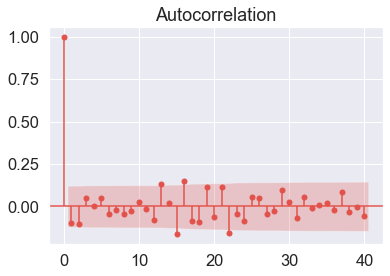

In [13]:
acf = smt.graphics.plot_acf(residual, lags=40 , alpha=0.05)
acf.show()

Assumption 4: Homoscedasticity

The simplest way to determine if this assumption is met is to create a plot of standardized residuals versus predicted values.

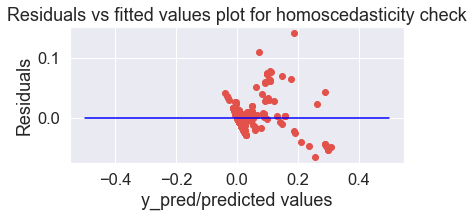

In [14]:
fig, ax = plt.subplots(figsize=(6,2.5))
_ = ax.scatter(y_pred, residual)
plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')
p = sns.lineplot([-0.5,0.5],[0,0], color = 'blue')
p = plt.title('Residuals vs fitted values plot for homoscedasticity check')

Assumption 5: Multivariate Normality

Check the assumption visually using Q-Q plots.


<AxesSubplot:xlabel='LTC_Mortality_Rate', ylabel='Density'>

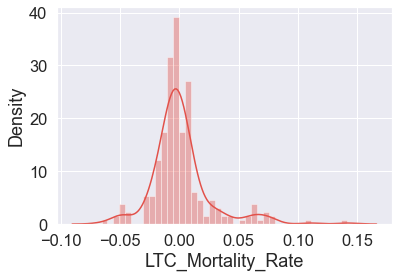

In [15]:
sns.distplot(residual)

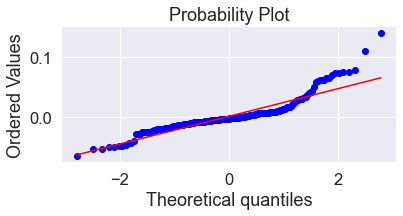

In [16]:
fig, ax = plt.subplots(figsize=(6,2.5))
_, (__, ___, r) = sp.stats.probplot(residual, plot=ax, fit=True)

In [17]:
np.mean(residual)

0.0011052775488057018

### Machine Learning Models

In [18]:
from sklearn.linear_model import Lasso 
lasso_reg = Lasso(alpha = 0.1)

from sklearn.linear_model import Ridge 
ridge_reg = Ridge(alpha = 1.0)

from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor(n_estimators = 100)

from sklearn.svm import SVR
svr_reg = SVR(kernel = 'rbf')

models = {'Lasso Regression':lasso_reg, 'Ridge Regression':ridge_reg, 
          'Random Forest':rf_reg,'Support Vector Regression': svr_reg}

X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

In [19]:
ml_model = []
r2_mean = []
mae_mean = []
rmse_mean = []
time_mean = []

for i in models:
    if i == 'Support Vector Regression' or i == 'Lasso Regression':
        y = y.reshape(len(y),1)
    
    r2 = []
    mae = []
    rmse = []
    time_used = []
    
    for j in range(10):
        
        begin_time = time.time()
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        if i == 'Support Vector Regression' or i == 'Lasso Regression':
            scaler_y = StandardScaler()
            scaler_y.fit(y_train)
            y_train = scaler_y.transform(y_train)
        
        models[i].fit(X_train_scaled, y_train)
        
        y_pred = models[i].predict(X_test_scaled)
        if i == 'Support Vector Regression' or i == 'Lasso Regression':
            y_pred = scaler_y.inverse_transform(y_pred)
        
        r2.append(r2_score(y_test, y_pred))
        mae.append(mean_absolute_error(y_test, y_pred))
        rmse.append(math.sqrt(mean_squared_error(y_test, y_pred)))
        
        end_time = time.time() - begin_time
        time_used.append(end_time)
    ml_model.append(i)
    r2_mean.append(statistics.mean(r2))
    mae_mean.append(statistics.mean(mae))
    rmse_mean.append(statistics.mean(rmse))
    time_mean.append(statistics.mean(time_used))
    
metrics = {'Model':ml_model, 'R Squared': r2_mean, 'Mean Absolute Error': mae_mean, 
           'Root Mean Square Error': rmse_mean, 'Runtime':time_mean}

result = pd.DataFrame(metrics)
result


,Model,R Squared,Mean Absolute Error,Root Mean Square Error,Runtime
0,Lasso Regression,0.828757,0.017698,0.030699,0.005684
1,Ridge Regression,0.874450,0.016336,0.026559,0.006383
2,Random Forest,0.995543,0.001015,0.004889,0.557394
3,Support Vector Regression,0.979824,0.006128,0.010399,0.057586


In [20]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = rf_reg, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f}%".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f}%".format(accuracies.std()*100)) # std checks the variance among the accuracies

Accuracy: 99.54%
Standard Deviation: 0.40%


In [21]:
#!pip install xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

xgb_reg = XGBRegressor(n_estimate = 100, subsample = 0.9,colsample_bynode = 0.2)
cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1)

scoring = {'R Squared':"r2",
           'Mean Absolute Error':"neg_mean_absolute_error", 
           'Root Mean Square Error':"neg_root_mean_squared_error"}
error_metrics = pd.DataFrame()
time_used = []
begin_time = time.time()
for scor in scoring:
    score = []
    n_cross = cross_val_score(xgb_reg, X, y, scoring = scoring[scor],cv = cv, n_jobs = -1)
    score.append(n_cross.mean())
    error_metrics[scor] = pd.Series(score)
    end_time = time.time() - begin_time
    time_used.append(end_time)
time_mean = statistics.mean(time_used)
error_metrics['Runtime'] = time_mean
error_metrics.insert(0,"Model", "XGBRegressor")
error_metrics

,Model,R Squared,Mean Absolute Error,Root Mean Square Error,Runtime
0,XGBRegressor,0.975814,-0.004791,-0.011086,9.373848


In [22]:
pd.concat([result,error_metrics])

,Model,R Squared,Mean Absolute Error,Root Mean Square Error,Runtime
0,Lasso Regression,0.828757,0.017698,0.030699,0.005684
1,Ridge Regression,0.874450,0.016336,0.026559,0.006383
2,Random Forest,0.995543,0.001015,0.004889,0.557394
3,Support Vector Regression,0.979824,0.006128,0.010399,0.057586
0,XGBRegressor,0.975814,-0.004791,-0.011086,9.373848
